In [52]:
#importing numpy and pandas

import numpy as np
import pandas as pd


# Importing training and test data

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')


# Examining training data to see what transformations need to be made

print(len(train_data))
print(train_data.head())

891
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S 

Looking at the data, we can see things that need fixing. First we can see that some columns contain null values: we need to check for these and determine what to do with them. Second, several columns contain strings that cannot be passed to our model, e.g., "Sex"; these will need to be replaced with numerical values.

We fill the null values in "Age" and "Fare", drop rows with null values in "Embarked" as there are only 2 of them and there is no convenient way to fill them, and ignore the null values in "Cabin" as 1) there are too many of them and 2) "Cabin" would not be a useful feature for our analysis.

In [53]:
# Checking for null values

print('Train')
print(train_data.isnull().sum())
print('\nTest')
print(test_data.isnull().sum())


# Null values in Age, Cabin and Embarked

# Replacing null values in "Age" with mean age

mean_age = train_data.Age.mean()
test_mean_age = test_data.Age.mean()

train_data.Age.fillna(mean_age, inplace=True)
test_data.Age.fillna(test_mean_age, inplace=True)

# Removing records from train with Null values in "Embarked"

train_data.dropna(subset=['Embarked'], inplace=True)

# Identifying test record with missing fare

print(test_data[test_data['Fare'].isnull()])

# Passenger is in 3rd Class and embarked at Southampton; finding mean fare for 3rd class Southampton passengers

third_class_mean = test_data[(test_data['Pclass'] == 3) & (test_data['Embarked'] == 'S')].Fare.mean()

test_data.Fare.fillna(third_class_mean, inplace=True)

#Final check for null values (Ignoring "Cabin" null values as there are too many to drop and nothing clear to fill with)

print('Train')
print(train_data.isnull().sum())

print('\nTest')
print(test_data.isnull().sum())


Train
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Test
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
     PassengerId  Pclass                Name   Sex   Age  SibSp  Parch Ticket  \
152         1044       3  Storey, Mr. Thomas  male  60.5      0      0   3701   

     Fare Cabin Embarked  
152   NaN   NaN        S  
Train
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

Test
PassengerId      0
Pclass           0
Name             

We give a numerical representation of "Sex", making male 0 and female 1. We also code dummy variables for "Embarked", taking Queenstown as our reference, and for "Passenger Class", taking second class as our reference. We choose second class because the disparity between first and third class passengers will be greater than between first and second or second and third.

In [54]:
#"Sex" and "Embarked" contain non-numerical values
# Giving numerical representations of "Sex"

train_data['Sex'] = train_data['Sex'].apply(lambda x: 0 if x == "male" else 1)
test_data['Sex'] = test_data['Sex'].apply(lambda x: 0 if x == "male" else 1)

# Coding dummy variables for numerical representations of point of Embarkation

train_data['qvs'] = train_data['Embarked'].apply(lambda x: 1 if x == 'S' else 0)
train_data['qvc'] = train_data['Embarked'].apply(lambda x: 1 if x == 'C' else 0)

test_data['qvs'] = test_data['Embarked'].apply(lambda x: 1 if x == 'S' else 0)
test_data['qvc'] = test_data['Embarked'].apply(lambda x: 1 if x == 'C' else 0)


# Coding dummy variables for Passenger Class

train_data['p2vp1'] = train_data['Pclass'].apply(lambda x: 1 if x == 1 else 0)
train_data['p2vp3'] = train_data['Pclass'].apply(lambda x: 1 if x == 3 else 0)

test_data['p2vp1'] = test_data['Pclass'].apply(lambda x: 1 if x == 1 else 0)
test_data['p2vp3'] = test_data['Pclass'].apply(lambda x: 1 if x == 3 else 0)

print(train_data.head(10))
        

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name  Sex        Age  SibSp  \
0                            Braund, Mr. Owen Harris    0  22.000000      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    1  38.000000      1   
2                             Heikkinen, Miss. Laina    1  26.000000      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    1  35.000000      1   
4                           Allen, Mr. William Henry    0  35.000000      0   
5                                   Moran, Mr. James    0  29.699118      0   
6                            McCarthy, Mr. Timothy

In [55]:

#Separating features from target

cleaned_data = train_data[['p2vp1', 'p2vp3', 'Sex', 'Age',\
                           'SibSp', 'Parch', 'Fare', 'qvs', 'qvc']]

cleaned_test_data = test_data[['p2vp1', 'p2vp3', 'Sex', 'Age',\
                           'SibSp', 'Parch', 'Fare', 'qvs', 'qvc']]

target_data = train_data[['Survived']]
target_data = target_data.iloc[:, -1].values

print(cleaned_data.head())




   p2vp1  p2vp3  Sex   Age  SibSp  Parch     Fare  qvs  qvc
0      0      1    0  22.0      1      0   7.2500    1    0
1      1      0    1  38.0      1      0  71.2833    0    1
2      0      1    1  26.0      0      0   7.9250    1    0
3      1      0    1  35.0      1      0  53.1000    1    0
4      0      1    0  35.0      0      0   8.0500    1    0


I wanted to test the effect that different methods of scaling would have on the accuracy of the model, so I tested using unscaled, unit-scaled and standardised data.

In [56]:
# First pass: logistic regression without scaling using Scikit-Learn

from sklearn.linear_model import LogisticRegression

unscaled_log_model = LogisticRegression()

unscaled_log_model.fit(cleaned_data, target_data)

#checking coeffs and R^2

print(unscaled_log_model.coef_)
print(unscaled_log_model.score(cleaned_data, target_data))






[[ 8.88427871e-01 -1.14177151e+00  2.61082889e+00 -3.81099701e-02
  -3.11550001e-01 -9.02315509e-02  2.48383042e-03 -2.71093966e-01
   1.94417792e-01]]
0.8042744656917885


C:\Users\Mike\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [57]:
#Second pass: Logistic regression with unit scaling

from sklearn.preprocessing import MinMaxScaler

unit_scaler = MinMaxScaler()

unit_scaled_data = pd.DataFrame(unit_scaler.fit_transform(cleaned_data))


# producing LR model with unit scaled data

unit_scaled_log_model = LogisticRegression()

unit_scaled_log_model.fit(unit_scaled_data, target_data)

#checking coeffs and R^2

print(unit_scaled_log_model.coef_)
print(unit_scaled_log_model.score(unit_scaled_data, target_data))



[[ 0.83593194 -1.16706398  2.54829678 -2.13664842 -1.39842426 -0.40663929
   0.48115022 -0.40100799  0.09612094]]
0.8020247469066367


In [58]:
# Third pass: Logistic regression with standardisation

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_data = pd.DataFrame(scaler.fit_transform(cleaned_data))
scaled_test_data = pd.DataFrame(scaler.fit_transform(cleaned_test_data))

# producing LR model with unit scaled data
scaled_log_model = LogisticRegression()

scaled_log_model.fit(scaled_data, target_data)

#checking coeffs and R^2

print(scaled_log_model.coef_)
print(scaled_log_model.score(scaled_data, target_data))

# Highest R^2 so far

[[ 0.38911209 -0.60134545  1.27943211 -0.49993988 -0.34742874 -0.07490603
   0.11410341 -0.18203823  0.01525313]]
0.8042744656917885


Having examined different methods of scaling, I now want to build a new logistic regression model which uses GridSearchCV to choose the best penalty norm and value for C.

In [59]:
from sklearn.model_selection import GridSearchCV, KFold

ratio_val = np.arange(0.025, 0.035, step=0.001)
C_val = 2. ** np.arange(-5, 10, step=2)
grid_s = [{'C':C_val, 'l1_ratio': ratio_val}]
model = LogisticRegression(solver='saga', penalty='elasticnet')

log_model_cv = GridSearchCV(estimator=model, param_grid=grid_s, cv=KFold(n_splits=10))

log_model_cv.fit(scaled_data, target_data)

best_c = log_model_cv.best_params_['C']
best_ratio = log_model_cv.best_params_['l1_ratio']

print(best_c, best_ratio)

blr_model = LogisticRegression(solver='saga', C=best_c, penalty='elasticnet', l1_ratio=best_ratio)

blr_model.fit(scaled_data, target_data)

print(blr_model.score(scaled_data, target_data))


0.125 0.03200000000000001
0.8042744656917885


Having examined different methods of scaling with logistic regression, I now want to test different methods of classification, specifically K Nearest Neighbors, Random Forest and Support Vector Classification.

I begin with K Neighbors. As the value of "k" needs to be put in manually, I begin by testing the accuracy of different values for K, looking for the elbow shape. To do this, I need to first generate a testing and training set from the Kaggle training data.

In [60]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(scaled_data, target_data, test_size = 0.25, random_state=1)



I then produced a graph of accuracies for differing values of K. This suggested a variety of possible values for k, e.g., 2, 6, 18. However, as I was worried about overfitting, I also plotted a validation curve for different values of k.

From the validation curve, we can see that there is overfitting at low values of k. The cross-validation score peaks at k=23, while the training score is roughly level, so I decided to use k=23.

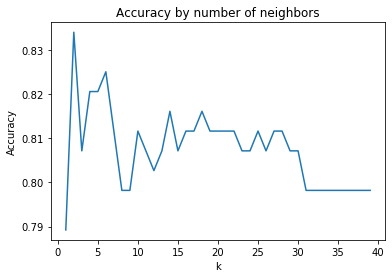

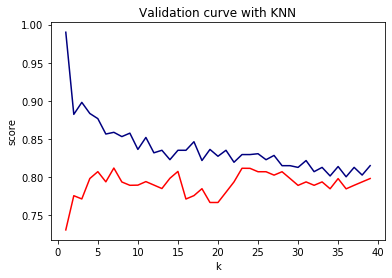

In [61]:
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
from sklearn.model_selection import validation_curve

#defining an empty list to hold scores

k_vals = range(1, 40)
k_scores = []

for k in range(1, 40):
    k_model = KNeighborsClassifier(n_neighbors = k)
    k_model.fit(x_train, y_train)
    k_scores.append(k_model.score(x_test, y_test))


plt.plot(k_vals, k_scores)
plt.title('Accuracy by number of neighbors')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show()


plt.clf()

train_results, test_results = validation_curve(KNeighborsClassifier(),\
                                               x_test, y_test, param_name="n_neighbors",\
                                               param_range=k_vals, scoring="accuracy", n_jobs=1)

#Geting the means of the train and test results

train_results_mean = np.mean(train_results, axis=1)
test_results_mean = np.mean(test_results, axis=1)


plt.title('Validation curve with KNN')
plt.xlabel('k')
plt.ylabel('score')
plt.plot(k_vals, train_results_mean, color='navy')
plt.plot(k_vals, test_results_mean, color='red')
plt.show()





In [62]:
#Testing k Nearest Neighbors model

k_model = KNeighborsClassifier(n_neighbors = 23)

k_model.fit(x_train, y_train)
print(k_model.score(x_test, y_test))

# Predicting values for Titanic data

k_y_pred = k_model.predict(scaled_test_data)

0.8071748878923767


Having tried logistic regression and k nearest neighbors, I now test Random Forest and Support Vector Classifier models

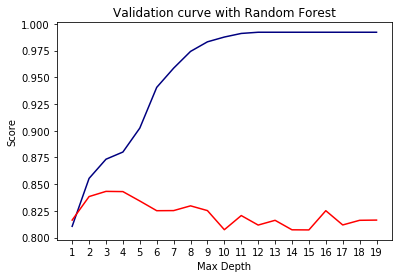

In [63]:
# Initialising Random Forest, using entropy as criterion because we are dealing with classes

from sklearn.ensemble import RandomForestClassifier

#determining ideal max depth

plt.clf()

rf_train_results, rf_test_results = validation_curve(RandomForestClassifier(),\
                                               x_test, y_test, param_name="max_depth",\
                                               param_range=range(1, 20), scoring="accuracy", n_jobs=1)

#Geting the means of the train and test results

rf_train_results_mean = np.mean(rf_train_results, axis=1)
rf_test_results_mean = np.mean(rf_test_results, axis=1)


plt.title('Validation curve with Random Forest')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.plot(range(1, 20), rf_train_results_mean, color='navy')
plt.plot(range(1, 20), rf_test_results_mean, color='red')
plt.xticks(range(1, 20))
plt.show()



A better way of determining the value of k (and also the number of tree) would be to use SearchGridCV again.

In [64]:
depth_val = np.arange(1, 10, step=1)
tree_num = np.arange(50, 150, step=10)
grid_rf = [{'max_depth': depth_val, 'n_estimators':tree_num}]
tree_model = RandomForestClassifier()

tree_cv = GridSearchCV(estimator=tree_model, param_grid=grid_rf, cv=KFold(n_splits=10))
tree_cv.fit(scaled_data, target_data)
best_depth = tree_cv.best_params_['max_depth']
best_n = tree_cv.best_params_['n_estimators']

rf_model = RandomForestClassifier(criterion="entropy", max_depth=best_depth, n_estimators=best_n)

rf_model.fit(x_train, y_train)

print(rf_model.score(x_test, y_test))

rf_y_pred = rf_model.predict(scaled_test_data)

0.8340807174887892


In [65]:
from sklearn.svm import SVC

svc_model = SVC(probability=True)

svc_model.fit(x_train, y_train)

print(svc_model.score(x_test, y_test))

svc_y_pred = svc_model.predict(scaled_test_data)

0.8161434977578476


Random forest has the highest accuracy score, suggesting it would be the best choice for our model. Another way of looking for the best model to use would be by plotting a Receiver Operating Characteristic curve, showing true positive rate against false positive rate, and finding which model gives the largest area under the curve.

<Figure size 432x288 with 0 Axes>

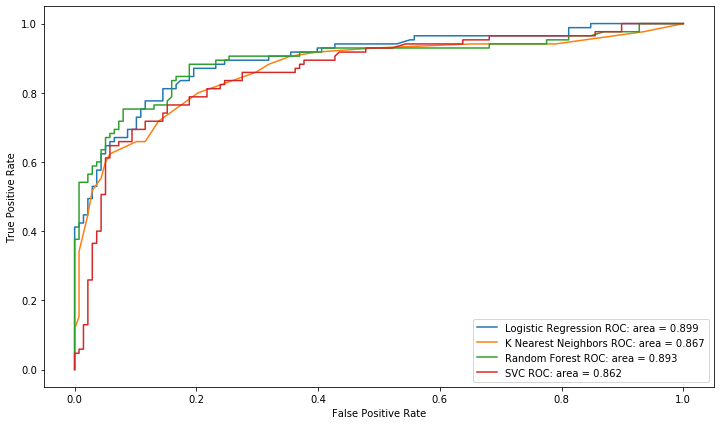

In [66]:
from sklearn.metrics import roc_curve, auc

plt.clf()

plt.figure(figsize=(12, 7))


# Calculating probabilities for Logistic Regression

lr_probs = blr_model.fit(x_train, y_train).predict_proba(x_test)

lr_fpr, lr_tpr, thresholds = roc_curve(y_test, lr_probs[:, 1])

lr_auc = auc(lr_fpr, lr_tpr)

plt.plot(lr_fpr, lr_tpr, label="Logistic Regression ROC: area = %0.3f" % lr_auc)


# For K Nearest Neighbors

k_probs = k_model.fit(x_train, y_train).predict_proba(x_test)

k_fpr, k_tpr, thresholds = roc_curve(y_test, k_probs[:, 1])

k_auc = auc(k_fpr, k_tpr)

plt.plot(k_fpr, k_tpr, label="K Nearest Neighbors ROC: area = %0.3f" % k_auc)


# For Random Forest

rf_probs = rf_model.fit(x_train, y_train).predict_proba(x_test)

rf_fpr, rf_tpr, thresholds = roc_curve(y_test, rf_probs[:, 1])

rf_auc = auc(rf_fpr, rf_tpr)

plt.plot(rf_fpr, rf_tpr, label="Random Forest ROC: area = %0.3f" % rf_auc)


# For SVC

svc_probs = svc_model.fit(x_train, y_train).predict_proba(x_test)

svc_fpr, svc_tpr, thresholds = roc_curve(y_test, svc_probs[:, 1])

svc_auc = auc(svc_fpr, svc_tpr)

plt.plot(svc_fpr, svc_tpr, label="SVC ROC: area = %0.3f" % svc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0)
plt.show()

Random forest has the highest accuracy score and Logistic regression has the highest ROC, so I decided to try submitting predictions from both.

In [67]:
# Scaling test data, creating results and producing .csv file

scaled_test_data = pd.DataFrame(scaler.fit_transform(cleaned_test_data))

log_y_pred = blr_model.predict(scaled_test_data)

rf_model.fit(scaled_data, target_data)

rf_y_pred = rf_model.predict(scaled_test_data)

def generate_results(y_pred, filename="titanic_results.csv"):
    results = pd.DataFrame({'PassengerId': range(892, 1310, 1), 'Survived': y_pred})
    print(results.head(10))
    results.to_csv(filename, index=False)

generate_results(log_y_pred, "titanic_results.csv")

generate_results(rf_y_pred, "titanic_rf_results.csv")

   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0
5          897         0
6          898         1
7          899         0
8          900         1
9          901         0
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1
5          897         0
6          898         1
7          899         0
8          900         1
9          901         0
